In [1]:
import numpy as np
import pymongo
#from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, log_loss, precision_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import sys
import math
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from operator import add
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.mlab as mlab
import socket

# Load data

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client["flowdb"]

In [3]:
#my data resulted in more data points under testP_agg so I used 
#that as the training collection instead of trainP_agg
p_train_coll = mydb["trainP_agg"]
p_test_coll = mydb["testP_agg"]
b_train_coll = mydb["aggb2"]
b_test_coll = mydb["testB_agg"]

n_test_coll = mydb["netflowagg"]

p_train = []
p_test = []
b_train = []
b_test = []
p_train_l = []
p_test_l = []
b_train_l = []
b_test_l = []
n_test = []


In [4]:

b_byte_dist_h = [0] * 256
b_ift_h = [0] * 15
p_byte_dist_h = [0] * 256
p_ift_h = [0] * 15
b_fl = np.zeros((10,10))
p_fl = np.zeros((10,10))


b_ifts = []
p_ifts = []
#b_flow_size = []
#p_flow_size = []
b_conv_size = []
p_conv_size = []
b_num_pkts = []
p_num_pkts = []
b_conv_time = []
p_conv_time = []



In [5]:
def getMD(doc, flag):
    tmp = []
    if doc['sp'][0] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['sp'][0])
        
    if doc['dp'][0] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['dp'][0])
    #tmp.append(doc['sp'][0])
    #tmp.append(doc['dp'][0])
    if doc['Source ASN'] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['Source ASN'])
    if doc['Dest ASN'] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['Dest ASN'])
    tmp.append(doc['bytes_in'])
    tmp.append(doc['bytes_out'])
    tmp.append(doc['total_bytes'])
    tmp.append(doc['num_pkts_in'])
    tmp.append(doc['num_pkts_out'])
    tmp.append(doc['total_num_pkts'])
    tmp.append(doc['# of flows'])
    tmp.append(doc['conv_time'])
    '''for i in range(256):
    
        if (doc['byte_dist'][i] != None):
            try:
                tmp.append(doc['byte_dist'][i])
                if (flag == 0):
                    b_byte_dist_h[i] += doc['byte_dist'][i]
                else:
                    p_byte_dist_h[i] += doc['byte_dist'][i] 
            except:
                tmp.append(0)
        else:
            tmp.append(0)'''
    return tmp

In [6]:
def getBD(doc, flag):
    tmp=[]
    for i in range(256):
        if (doc['byte_dist'][i] != None):
            try:
                tmp.append(doc['byte_dist'][i])
                if (flag == 0):
                    b_byte_dist_h[i] += doc['byte_dist'][i]
                else:
                    p_byte_dist_h[i] += doc['byte_dist'][i] 
            except:
                tmp.append(0)
        else:
            tmp.append(0)
    return tmp

In [7]:

def getIFTBuckets(doc, flag):
    tmp = []
    ifts = doc['ift']
    length = len(ifts)
    tmp.append(length)
    #tmp.append(np.mean(ifts))
    num = 15
    buckets = [0] * num
    sumi = 0
    avg_ift = 0
    for ift1 in ifts:
        if ift1 > 0:
           logift = math.log(ift1, 2)
        if ift1 == 0:
            buckets[0] += 1
            if(flag == 0):
                b_ift_h[0]+= 1
            elif flag == 1:
                p_ift_h[0] += 1
        elif logift <= 0:
            buckets[0] += 1
            if(flag == 0):
                b_ift_h[0]+= 1
            elif(flag == 1):
                p_ift_h[0] += 1
            sumi += ift1
        elif logift >= 14:
            buckets[14] += 1
            if(flag == 0):
                b_ift_h[14]+= 1
            elif (flag== 1):
                p_ift_h[14] += 1
            sumi += ift1
        else:
            buckets[int(math.floor(logift))] += 1
            if(flag == 0):
                b_ift_h[int(math.floor(logift))]+= 1
            elif flag == 1:
                p_ift_h[int(math.floor(logift))] += 1
            sumi += ift1
    
    if length > 1:
        avg_ift = float(sumi / length)
    tmp.append(avg_ift)
    tmp.extend(buckets)
    
    return tmp

In [8]:
def getIndividualFL(doc, flag):
    numRows = 10
    binSize = 200
    transMat = np.zeros((numRows, numRows))
    if len(doc['byte_array']) == 0:
        return list(transMat.flatten())
    elif len(doc['byte_array']) == 1:
        curFlowSize = min(int(doc['byte_array'][0] / binSize), numRows - 1)
        transMat[curFlowSize, curFlowSize] = 1
        return list(transMat.flatten())

    for i in range(1, len(doc['byte_array'])):
        prevFlowSize = min(int(doc['byte_array'][i-1] / binSize), numRows - 1)
        curFlowSize = min(int(doc['byte_array'][i] / binSize), numRows - 1)
        transMat[prevFlowSize, curFlowSize] += 1

    for i in range(numRows):
        if float(np.sum(transMat[i:i+1])) != 0:
            transMat[i:i+1] = transMat[i:i+1] / float(np.sum(transMat[i:i + 1]))
    for i in range(numRows):
        for j in range(numRows):
            if(flag == 0):
                b_fl[i][j] += transMat[i][j]
            elif(flag == 1):
                p_fl[i][j] += transMat[i][j]
    return list(transMat.flatten())

In [9]:
'''
use this to create the arrays. 
Collection- the collection to loop through,
data_set- the variable that the collection doc's are appended to
label_set- is the set that is used to train/test with the data set (pass in None if 
            its not all benign or all pirated), 
label- 1 for pirate, 0 for benign.
Chart- 1 to include in pirated graphs, 0 to include in benign graphs, anything else to
not include in either graphs
cond: used to specifiy any conditions to search for in the collection
bd: set as 1 to include byte dist in data_set
ift: set as 1 to include ift in data set. 
fl: set as 1 to include flow lengths in data set
ips: pass in blank array to fill with ip tuples of conversations
bytes: pass in blank array to fill with byte sizes of conversations
sp: pass in blank array to fill with source port #'s of conversations
dp: pass in blank array to fill with dest port #'s of conversations
'''
def set_up_array(collection, data_set, label_set=None, label=None, chart=-1,
                cond=None, bd=None, ift=None, fl=None, ips=None, bytes=None,
                sp=None, dp=None):
    for doc in collection.find(cond):
        tmpd = []
        tmp = getMD(doc, chart)
        tmpb = getBD(doc, chart)
        if (bd == 1 and (tmpb is None or len(tmpb) != 256)):
            tmpb = np.zeros(256)
        elif (bd == 1):
            tmpb = preprocessing.scale(tmpb)
        tmpift= getIFTBuckets(doc, chart)
        tmpind_fl = getIndividualFL(doc, chart)
        
        #sum_ift=0
        if (chart == 0):
            #get ift's
            for ift1 in doc['ift']:
                try:
                    b_ifts.append(ift1)
                    #sum_ift += ift
                except Exception as e:
                    print e
                    pass
            try:
                b_conv_size.append(doc['total_bytes'])
            except Exception as e:
                print e
                pass
            try:
                b_conv_time.append(doc['conv_time'])
            except Exception as e:
                print e
                pass
            try:
                b_num_pkts.append(doc['total_num_pkts'])
            except Exception as e:
                print e
                pass
        elif (chart == 1):
            for ift1 in doc['ift']:
                try:
                    p_ifts.append(ift1)
                    #sum_ift += ift
                except Exception as e:
                    print e
                    pass
            try:
                p_conv_size.append(doc['total_bytes'])
            except Exception as e:
                print e
                pass
            try:
                p_conv_time.append(doc['conv_time'])
            except Exception as e:
                print e
                pass
            try:
                p_num_pkts.append(doc['total_num_pkts'])
            except Exception as e:
                print e
                pass
        if ips != None:
            ips.append((doc['sa'], doc['da']))
        if bytes != None:
            bytes.append(doc['total_bytes'])
        if sp != None:
            sp.append(doc['sp'])
        if dp != None:
            dp.append(doc['dp'])
        
        tmpd.extend(tmp)
        if bd==1:
            tmpd.extend(tmpb)
        if ift == 1:
            tmpd.extend(tmpift)
        if fl == 1:
            tmpd.extend(tmpind_fl)
        data_set.append(tmpd)
        try:
            label_set.append(label)
        except Exception as e:
            print ('error passing label')
            pass
        
        #mp.append(sum_ift)

### set up training and testing data arrays

In [10]:
set_up_array(p_train_coll, p_train, p_train_l, label=1, chart=1, bd=1, fl=1)


In [11]:
set_up_array(p_test_coll, p_test, p_test_l, label=1, bd=1, fl=1)


In [12]:
set_up_array(b_train_coll, b_train, b_train_l, label=0, chart=0, bd=1, fl=1)


In [13]:
set_up_array(b_test_coll, b_test, b_test_l, label=0, bd=1, fl=1)

In [14]:
print len(p_train[0])
print len(b_train[0])
print len(p_test[0])
print len(b_test[0])

368
368
368
368


In [15]:
training_set = []
training_set.extend(b_train)
training_set.extend(p_train)
training_labels = []
training_labels.extend(b_train_l)
training_labels.extend(p_train_l)
training_set = np.array(training_set)
training_labels = np.array(training_labels)
b_train = np.array(b_train)
p_train = np.array(p_train)
b_train_l = np.array(b_train_l)
p_train_l = np.array(p_train_l)

In [16]:
test_set = []
test_labels = []
test_set.extend(b_test)
test_set.extend(p_test)
test_labels.extend(b_test_l)
test_labels.extend(p_test_l)
test_set = np.array(test_set)
test_labels = np.array(test_labels)
b_test = np.array(b_test)
p_test = np.array(p_test)
b_test_l = np.array(b_test_l)
p_test_l = np.array(p_test_l)

In [17]:
#neural_net = MLPClassifier(learning_rate_init=0.01)
#decision_tree = DecisionTreeClassifier(criterion='entropy')
#params = {'learning_rate_init': [0.001, 0.01, 0.1, 1]}
#nn = GridSearchCV(MLPClassifier(), params, scoring=make_scorer(accuracy_score),cv=10, n_jobs=-1)

# Graphs

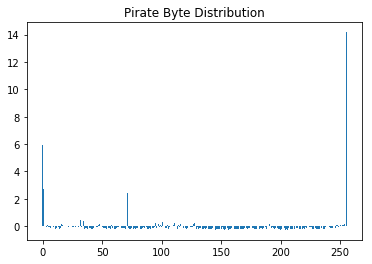

In [18]:
y_pos = np.arange(len(p_byte_dist_h))
x = preprocessing.scale(p_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Pirate Byte Distribution")
plt.show()

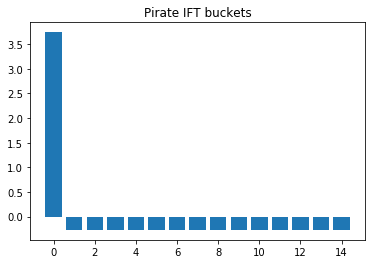

In [19]:
y_pos = np.arange(len(p_ift_h))
x = preprocessing.scale(p_ift_h)
plt.bar(y_pos, x)
plt.title("Pirate IFT buckets")
plt.show()

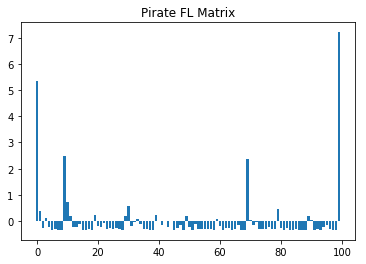

In [20]:
p_fl = p_fl.flatten()
y_pos = np.arange(len(p_fl))
x = preprocessing.scale(p_fl)
plt.bar(y_pos, x)
plt.title('Pirate FL Matrix')
plt.show()

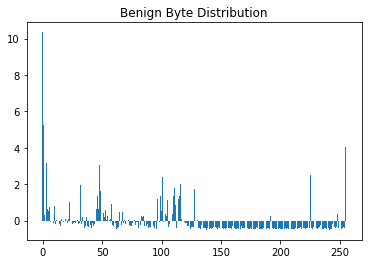

In [21]:
y_pos = np.arange(len(b_byte_dist_h))
x = preprocessing.scale(b_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Benign Byte Distribution")
plt.show()

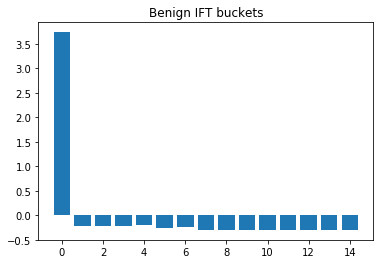

In [22]:
y_pos = np.arange(len(b_ift_h))
x = preprocessing.scale(b_ift_h)
plt.bar(y_pos, x)
plt.title("Benign IFT buckets")
plt.show()

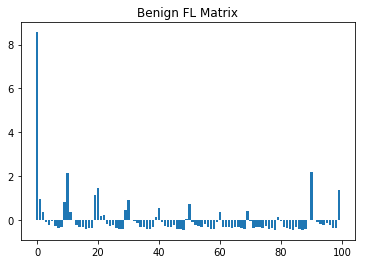

In [23]:
b_fl = b_fl.flatten()
y_pos = np.arange(len(b_fl))
x = preprocessing.scale(b_fl)
plt.bar(y_pos, x)
plt.title('Benign FL Matrix')
plt.show()

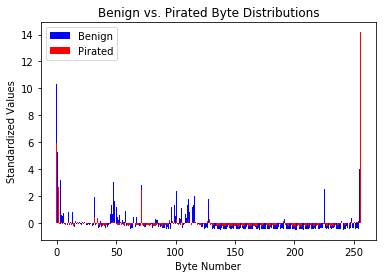

In [24]:
by_pos = np.arange(len(b_byte_dist_h))
b = preprocessing.scale(b_byte_dist_h)
py_pos = np.arange(len(p_byte_dist_h))
p = preprocessing.scale(p_byte_dist_h)

com = plt.subplot(111)
benign_box = com.bar(by_pos, b, color='b')
pirate_box = com.bar(py_pos+0.2, p, color='r')
com.legend((benign_box[0], pirate_box[0]), ('Benign', "Pirated"))
com.set_ylabel('Standardized Values')
com.set_xlabel('Byte Number')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Byte Distributions')
plt.show()

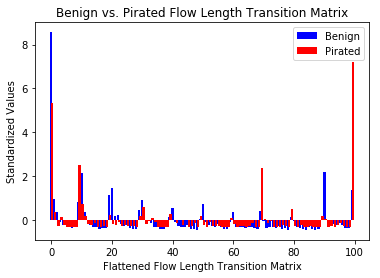

In [25]:
by_pos = np.arange(len(b_fl))
b = preprocessing.scale(b_fl)
py_pos = np.arange(len(p_fl))
p = preprocessing.scale(p_fl)

com = plt.subplot(111)
benign_box = com.bar(by_pos, b, color='b')
pirate_box = com.bar(py_pos+0.4, p, color='r')
com.legend((benign_box[0], pirate_box[0]), ('Benign', "Pirated"))
com.set_ylabel('Standardized Values')
com.set_xlabel('Flattened Flow Length Transition Matrix')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Flow Length Transition Matrix')
plt.show()

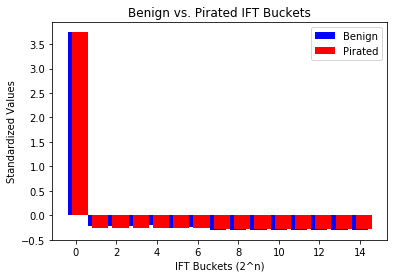

In [26]:
by_pos = np.arange(len(b_ift_h))
b = preprocessing.scale(b_ift_h)
py_pos = np.arange(len(p_ift_h))
p = preprocessing.scale(p_ift_h)

com = plt.subplot(111)
benign_box = com.bar(by_pos, b, color='b')
pirate_box = com.bar(py_pos+0.2, p, color='r')
com.legend((benign_box[0], pirate_box[0]), ('Benign', "Pirated"))
com.set_ylabel('Standardized Values')
com.set_xlabel('IFT Buckets (2^n)')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated IFT Buckets')
plt.show()

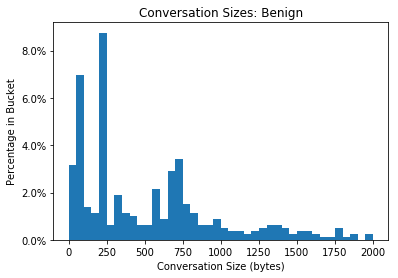

In [27]:
b2 = np.array(b_conv_size)
#b2 = b2[abs(b2 - np.mean(b2)) < 3 * np.std(b2)]
plt.hist(b2, weights=np.ones(len(b2))/len(b2), range=(0,2000), bins=40)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Conversation Size (bytes)')
plt.ylabel('Percentage in Bucket')
plt.title('Conversation Sizes: Benign')

plt.show()

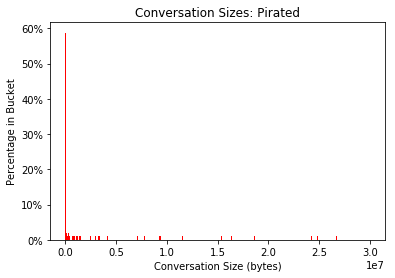

In [28]:
p2 = np.array(p_conv_size)
#p2 = p2[abs(p2 - np.mean(p2)) < 3 * np.std(p2)]
plt.hist(p2, weights=np.ones(len(p2))/len(p2), color='r', range=(0,30000000), bins=400)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Conversation Size (bytes)')
plt.ylabel('Percentage in Bucket')
plt.title('Conversation Sizes: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
       1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700., 1750.,
       1800., 1850., 1900., 1950., 2000.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


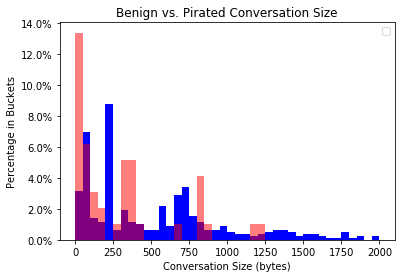

In [29]:
com = plt.subplot(111)
b_pkt_S = com.hist(b2, weights=np.ones(len(b2))/len(b2),
                    color='b', range=(0, 2000), bins=40)
p_pkt_S = com.hist(p2, weights=np.ones(len(p2))/len(p2),
                    color='r', range=(0,2000), bins=40, fc=(1, 0, 0, 0.5))
com.legend((b_pkt_S[1], p_pkt_S[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage in Buckets')
com.set_xlabel('Conversation Size (bytes)')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Conversation Size')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

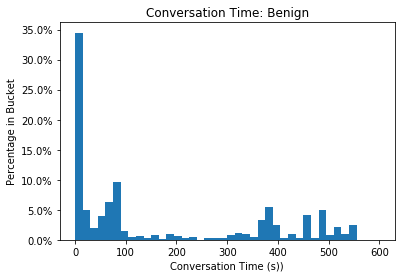

In [30]:
b_flows = np.array(b_conv_time)
b_flows = b_flows[abs(b_flows - np.mean(b_flows)) < 3 * np.std(b_flows)]
plt.hist(b_flows, weights=np.ones(len(b_flows))/len(b_flows), range=(0,600), bins=40)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Conversation Time (s))')
plt.ylabel('Percentage in Bucket')
plt.title('Conversation Time: Benign')

plt.show()

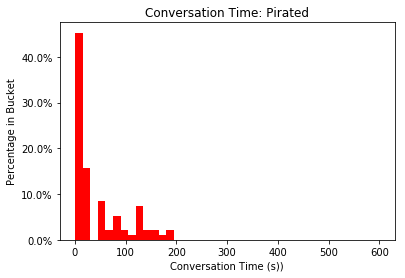

In [31]:
p_flows = np.array(p_conv_time)
p_flows = p_flows[abs(p_flows - np.mean(p_flows)) < 3 * np.std(p_flows)]
plt.hist(p_flows, weights=np.ones(len(p_flows))/len(p_flows), range=(0,600), bins=40, color='r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Conversation Time (s))')
plt.ylabel('Percentage in Bucket')
plt.title('Conversation Time: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
       165., 180., 195., 210., 225., 240., 255., 270., 285., 300., 315.,
       330., 345., 360., 375., 390., 405., 420., 435., 450., 465., 480.,
       495., 510., 525., 540., 555., 570., 585., 600.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


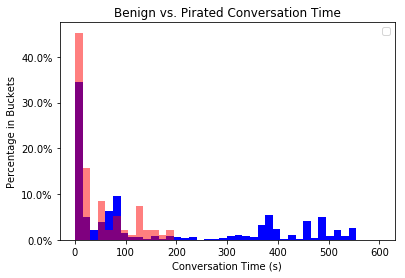

In [32]:
com = plt.subplot(111)
b_flow_s = com.hist(b_flows, weights=np.ones(len(b_flows))/len(b_flows),
                    color='b', range=(0, 600), bins=40)
p_flow_s = com.hist(p_flows, weights=np.ones(len(p_flows))/len(p_flows),
                    color='r', range=(0,600), bins=40, fc=(1, 0, 0, 0.5))
com.legend((b_flow_s[1], p_flow_s[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage in Buckets')
com.set_xlabel('Conversation Time (s)')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Conversation Time')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


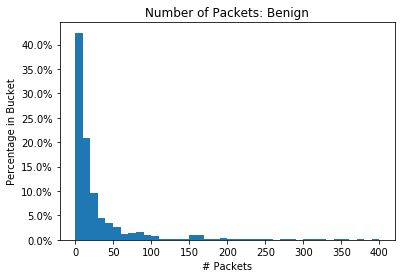

In [33]:
b_np = np.array(b_num_pkts)
b_np = b_np[abs(b_np - np.mean(b_np)) < 3 * np.std(b_np)]
plt.hist(b_np, weights=np.ones(len(b_np))/len(b_np), range=(0,400), bins=40)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('# Packets')
plt.ylabel('Percentage in Bucket')
plt.title('Number of Packets: Benign')

plt.show()

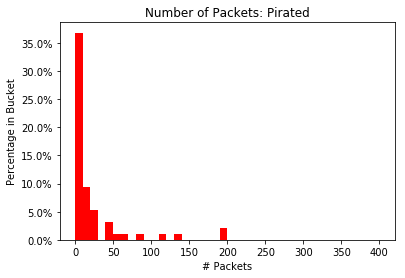

In [34]:
p_np = np.array(p_num_pkts)
p_np = p_np[abs(p_np - np.mean(p_np)) < 3 * np.std(p_np)]
plt.hist(p_np, weights=np.ones(len(p_np))/len(p_np), color='r', bins=40, range=(0,400))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('# Packets')
plt.ylabel('Percentage in Bucket')
plt.title('Number of Packets: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350., 360., 370., 380., 390., 400.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


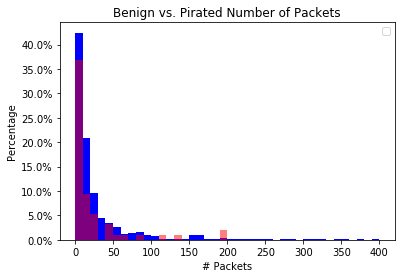

In [35]:
com = plt.subplot(111)
b_np_ = com.hist(b_np, weights=np.ones(len(b_np))/len(b_np),
                    color='b', range=(0, 400), bins=40)
p_np_ = com.hist(p_np, weights=np.ones(len(p_np))/len(p_np),
                    color='r', range=(0,400), bins=40, fc=(1, 0, 0, 0.5))
com.legend((b_np_[1], p_np_[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage')
com.set_xlabel('# Packets')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Number of Packets')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

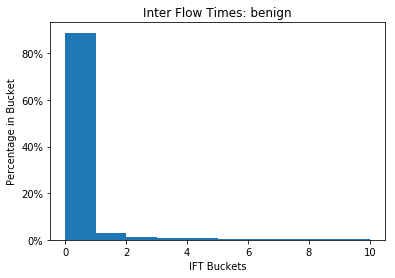

In [36]:
b_ift2 = np.array([b_ifts])

b_ift2 = b_ift2[abs(b_ift2 - np.mean(b_ift2)) < 3 * np.std(b_ift2)]
plt.hist(b_ift2, weights=np.ones(len(b_ift2))/len(b_ift2), bins=10, range=(0,10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('IFT Buckets')
plt.ylabel('Percentage in Bucket')
plt.title('Inter Flow Times: benign')

plt.show()

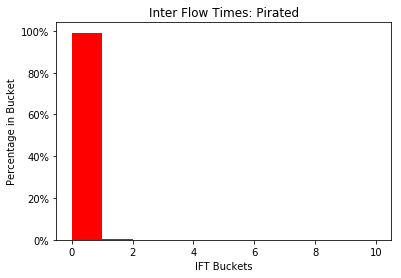

In [37]:
p_ipt2 = np.array([p_ifts])

p_ipt2 = p_ipt2[abs(p_ipt2 - np.mean(p_ipt2)) < 3 * np.std(p_ipt2)]
plt.hist(p_ipt2, weights=np.ones(len(p_ipt2))/len(p_ipt2), bins=10, range=(0,10), color='r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('IFT Buckets')
plt.ylabel('Percentage in Bucket')
plt.title('Inter Flow Times: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


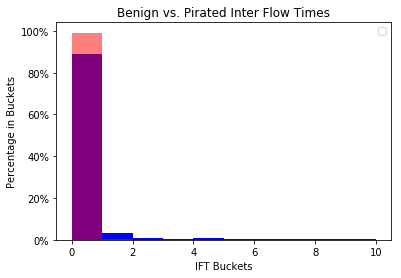

In [38]:
com = plt.subplot(111)
b_ipt_ = com.hist(b_ift2, weights=np.ones(len(b_ift2))/len(b_ift2),
                    color='b', range=(0, 10), bins=10)
p_ipt_ = com.hist(p_ipt2, weights=np.ones(len(p_ipt2))/len(p_ipt2),
                    color='r', range=(0,10), bins=10, fc=(1, 0, 0, 0.5))
com.legend((b_ipt_[1], p_ipt_[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage in Buckets')
com.set_xlabel('IFT Buckets')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Inter Flow Times')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# Begin ML 

#### Scoring Functions:

In [39]:
metrics = [accuracy_score, precision_score, f1_score, log_loss]

In [40]:
def score_clf(clf, y_true, t_set):
    results = []
    #results.append(accuracy_score(y_true, y_pred))
    #results.append(precision_score(y_true, y_pred))
    y_pred = clf.predict(t_set)
    for metric in metrics:
        results.append(metric(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    #True Pos Rate = TP/FN+TP
    results.append(float(cm[0][0])/(cm[1][0] + cm[0][0]))
    #False Pos Rate = FP/FP+TN
    results.append(float(cm[0][1])/(cm[0][1]+cm[1][1]))
 
    return results

#### Classifiers:

In [41]:
#nn.fit(training_set, training_labels)
#print nn.cv_results_
#print (training_set.shape, training_labels.shape)
smote = SMOTE(1.0)
#smotenc = SMOTENC(1.0)
rs_x, rs_y = smote.fit_sample(training_set, training_labels)
#nc_x, nc_y = smotenc.fit_sample(training_set, training_labels)
#print(rs_x.shape, rs_y.shape)
#print(nc_x.shape, nc_y.shape)

In [42]:
rf = RandomForestClassifier(bootstrap=False)
rf.fit(training_set, training_labels)
#rf.fit(rs_x, rs_y)

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
log_reg = LogisticRegression()
log_reg.fit(training_set, training_labels)
#log_reg.fit(rs_x, rs_y)

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
d_tree = DecisionTreeClassifier()
d_tree.fit(training_set, training_labels)
#d_tree.fit(rs_x, rs_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [45]:
dt_boost = AdaBoostClassifier(DecisionTreeClassifier())
dt_boost.fit(training_set, training_labels)
#dt_boost.fit(rs_x, rs_y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [46]:
neural_net = MLPClassifier()
neural_net.fit(training_set, training_labels)
#neural_net.fit(rs_x, rs_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [47]:
res=[]
clfs = [log_reg, d_tree, rf, dt_boost, neural_net]

for clf in clfs:
    res.append(score_clf(clf, test_labels, test_set))
clf_names = ['LR:','DT:', 'RF:', 'BoostDT:', 'NN:']

In [48]:
score_df = pd.DataFrame(res)
score_df.columns = ['Accuracy', 'Precision', 'F1', 'Log_Loss', 'TruePosRate', 'FalsePosRate']
score_df.index = clf_names

In [49]:
score_df

,Accuracy,Precision,F1,Log_Loss,TruePosRate,FalsePosRate
LR:,0.530952,1.000000,0.116592,16.200331,0.515971,0.000000
DT:,0.685714,0.819672,0.602410,10.855086,0.630872,0.180328
RF:,0.638095,0.862500,0.475862,12.499769,0.585294,0.137500
BoostDT:,0.685714,0.800000,0.611765,10.855094,0.634483,0.200000
NN:,0.647619,0.746032,0.559524,12.170868,0.605442,0.253968


In [50]:
print len(b_train)
print len(p_train)

788
97


In [51]:
print float(len(p_test)) / (len(p_test) + len(b_test))

0.5
